# **Imports**

Esse bloco importa as bibliotecas que serão usadas para carregar, treinar e avaliar o modelo SVM, além de definir uma semente (RANDOM_STATE) para garantir resultados reproduzíveis.

In [1]:
# Importa bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    KFold, StratifiedShuffleSplit, GridSearchCV, cross_val_score
)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define semente para resultados reproduzíveis
RANDOM_STATE = 42

# **Carregando Dataset**

Esse bloco carrega o dataset de diabetes diretamente de um link, define os nomes das colunas e separa os atributos (X) da variável alvo (y). No final, mostra o tamanho do conjunto de dados e a distribuição das classes.

In [2]:
columns = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]

# Lê o CSV da internet
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, names=columns)

# Separa os atributos (X) da variável alvo (y)
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

# Mostra o tamanho do dataset e a distribuição das classes
print("Shape do dataset:", X.shape)
print("Distribuição de classes:", np.bincount(y))

Shape do dataset: (768, 8)
Distribuição de classes: [500 268]


# **Pré-processamento**

Esse bloco trata valores faltantes do dataset. Ele substitui os zeros (que não fazem sentido em variáveis como glicose ou pressão) por NaN e depois preenche esses espaços com a média de cada coluna.

In [3]:
features_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Substitui zeros por NaN e preenche com a média da coluna
for col in features_with_missing:
    X[col] = X[col].replace(0, np.nan)
    X[col] = X[col].fillna(X[col].mean())


# **Pipeline SVM**

Esse bloco cria um pipeline que primeiro padroniza os dados com o StandardScaler e depois aplica o classificador SVM. Em seguida, define a grade de parâmetros (param_grid) que será testada no GridSearchCV, variando o kernel, o valor de C e, no caso do RBF, também o gamma.

In [4]:
# Cria o pipeline com padronização e SVM
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=RANDOM_STATE))
])

# Define a grade de parâmetros para o GridSearchCV
param_grid = [
    {"svc__kernel": ["linear"], "svc__C": [0.01, 0.1, 1, 10, 100]},
    {"svc__kernel": ["rbf"], "svc__C": [0.01, 0.1, 1, 10, 100], "svc__gamma": ["scale", 0.01, 0.001]}
]

# **Validação: Kfold-10**

Esse bloco aplica a validação cruzada usando KFold com 10 divisões. Ele usa o GridSearchCV para encontrar os melhores hiperparâmetros do SVM, calcula a acurácia média e o desvio padrão, e exibe uma matriz de confusão e um relatório de classificação.


===== KFold-10 =====
Melhores parâmetros: {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Acurácia média: 0.7656 ± 0.0486


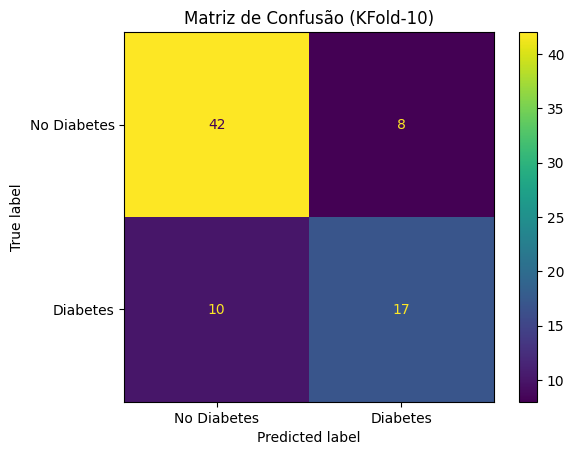


Relatório de classificação (KFold-10 exemplo):
              precision    recall  f1-score   support

 No Diabetes       0.81      0.84      0.82        50
    Diabetes       0.68      0.63      0.65        27

    accuracy                           0.77        77
   macro avg       0.74      0.73      0.74        77
weighted avg       0.76      0.77      0.76        77



In [5]:
# Cria KFold com 10 divisões e embaralhamento
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Executa GridSearchCV usando KFold
gs_kf = GridSearchCV(pipe, param_grid, cv=kf, n_jobs=-1)
gs_kf.fit(X, y)

# Mostra resultados do GridSearchCV
print("\n===== KFold-10 =====")
print("Melhores parâmetros:", gs_kf.best_params_)

# Calcula acurácia média e desvio padrão usando cross-validation
scores_kf = cross_val_score(gs_kf.best_estimator_, X, y, cv=kf, n_jobs=-1)
print(f"Acurácia média: {scores_kf.mean():.4f} ± {scores_kf.std():.4f}")

# Seleciona o primeiro fold para exemplo de matriz de confusão
for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model = gs_kf.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    break

# Plota a matriz de confusão do primeiro fold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["No Diabetes", "Diabetes"]
)
plt.title("Matriz de Confusão (KFold-10)")
plt.show()

# Mostra relatório de classificação do primeiro fold
print("\nRelatório de classificação (KFold-10 exemplo):")
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))


# **Validação: StratifiedShuffleSplit (30%, n=10)**

Esse bloco aplica a validação cruzada com StratifiedShuffleSplit (10 divisões, 30% para teste). Ele usa o GridSearchCV para buscar os melhores hiperparâmetros do SVM, calcula a acurácia média com desvio padrão e exibe uma matriz de confusão e um relatório de classificação de uma das divisões como exemplo.


===== StratifiedShuffleSplit (30%, n=10) =====
Melhores parâmetros: {'svc__C': 0.01, 'svc__kernel': 'linear'}
Acurácia média: 0.7576 ± 0.0233


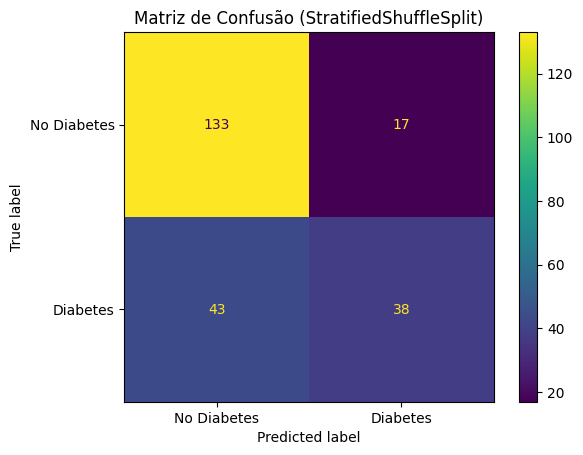


Relatório de classificação (StratifiedShuffleSplit exemplo):
              precision    recall  f1-score   support

 No Diabetes       0.76      0.89      0.82       150
    Diabetes       0.69      0.47      0.56        81

    accuracy                           0.74       231
   macro avg       0.72      0.68      0.69       231
weighted avg       0.73      0.74      0.73       231



In [6]:
# Cria StratifiedShuffleSplit com 10 divisões e 30% para teste
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=RANDOM_STATE)

# Executa GridSearchCV usando StratifiedShuffleSplit
gs_sss = GridSearchCV(pipe, param_grid, cv=sss, n_jobs=-1)
gs_sss.fit(X, y)

# Mostra resultados do GridSearchCV
print("\n===== StratifiedShuffleSplit (30%, n=10) =====")
print("Melhores parâmetros:", gs_sss.best_params_)

# Calcula acurácia média e desvio padrão usando cross-validation
scores_sss = cross_val_score(gs_sss.best_estimator_, X, y, cv=sss, n_jobs=-1)
print(f"Acurácia média: {scores_sss.mean():.4f} ± {scores_sss.std():.4f}")

# Seleciona o primeiro split para exemplo de matriz de confusão
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model = gs_sss.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    break

# Plota a matriz de confusão do primeiro split
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["No Diabetes", "Diabetes"]
)
plt.title("Matriz de Confusão (StratifiedShuffleSplit)")
plt.show()

# Mostra relatório de classificação do primeiro split
print("\nRelatório de classificação (StratifiedShuffleSplit exemplo):")
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))